# Predicting Contract Success using Random Forest and sklearn

There are many users of online insurance platforms and these companies would like to run analytics on and predict the features that lead to contract success. 

In this notebook, we will leverage Watson Studio to do the following:

1. Ingest historical contract success and failure data
2. Visualize historical contract success and failure data to get a better understanding of data to build hypotheses for prediction
3. Leverage sklearn library to build classification model that predicts whether a contact's success or failure
4. Expose the classification model as RESTful API endpoint for the end-to-end contact prediction and risk remediation application

<img src="https://github.com/snyderbrian/Reducing-Severe-Weather-Risk/blob/master/data_science_modelops_team_sport.png?raw=true" width="800" height="500" align="center"/>

<a id="top"></a>
## Table of Contents

1. [Load libraries](#load_libraries)
2. [Load and visualize contract data](#load_data)
3. [Prepare data for building classification model](#prepare_data)
4. [Train classification model and test model performance](#build_model)
5. [Save model to ML repository and expose it as REST API endpoint](#save_model)
6. [Summary](#summary)

<a id="load_libraries"></a>
## 1. Load libraries
[Top](#top)

Running the following cell will load all libraries needed to load, visualize, prepare the data and build ML models for our use case

In [1]:
#Uncomment and run once to install the package in your runtime environment
!pip install sklearn-pandas==1.8.0

In [2]:
# If the following cell doesn't work, please un-comment out the next line and do upgrade the patplotlib package. When the upgrade is done, restart the kernal and start from the beginning again. 
!pip install --user --upgrade matplotlib

     |████████████████████████████████| 11.2 MB 16.7 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import json
import matplotlib.pyplot as plt
%matplotlib inline

<a id="load_data"></a>
## 2. Load data example
[Top](#top)

Data can be easily loaded using point-and-click functionality. 
The following image illustrates how to load a dataset assuming it is called "Project Analysis.csv". 
The file can be located by its name and inserted into the notebook as a **pandas** dataframe shown below:

The interface comes up with a generic name, so it is good practice to rename the dataframe to match context of the use case. In this case, we will use project_success.

In [4]:
#Insert Data Source here from your Find and Add Data button in the uppoe right with zeros and 1's.

df_contact_success_pd = pd.read_csv(body)
df_contact_success_pd.head()



,Successful Contract,Effective Date,Termination Date,Duration Days,Duration Range,Contract Amount (yr),Contract Range,Vendor Quality,On Time,Budget,...,Amendment,Deliverables,Force Majeure,Liability,Payment Terms & Billing,Term & Termination,Contract Type,Location,Currency,Intellectual Property
0,Y,3/8/2023,1/24/2025,688,Medium,10500000,High,1,Y,Under Budget,...,Y,N,Y,N,Y,Y,Technical Services Agreement,United States,USD,N
1,Y,2/8/2023,6/17/2024,495,Medium,10000000,High,1,Y,At Budget,...,Y,Y,N,N,Y,N,Master Agreement,United Kingdom,Euro,Y
2,Y,12/23/2023,5/3/2024,132,Low,8000000,High,1,Y,At Budget,...,Y,N,N,N,N,N,Base Agreement,England,Euro,Y
3,Y,10/31/2023,12/11/2023,41,Low,4500000,High,1,N,Under Budget,...,N,N,Y,N,N,Y,Base Agreement,U.S.,USD,Y
4,Y,2/28/2023,6/4/2025,827,High,4000000,High,1,Y,Over Budget,...,N,Y,Y,N,N,Y,Base Agreement,U.S.,USD,Y


Data Visualization is key step in data mining process that helps better understand data before it can be prepared for building ML models

In [5]:
df_contact_success_pd.dtypes

Successful Contract        object
Effective Date             object
Termination Date           object
Duration Days               int64
Duration Range             object
Contract Amount (yr)        int64
Contract Range             object
Vendor Quality              int64
On Time                    object
Budget                     object
Deliverable Type           object
Sourcing Organization      object
Expense Type               object
Budget Line Item           object
Auto Renewal               object
Indemnification            object
Supplier                   object
Contract Number            object
Disclaimer                 object
Oligation                  object
Amendment                  object
Deliverables               object
Force Majeure              object
Liability                  object
Payment Terms & Billing    object
Term & Termination         object
Contract Type              object
Location                   object
Currency                   object
Intellectual P

In [6]:
df_contact_success_pd.describe()

,Duration Days,Contract Amount (yr),Vendor Quality
count,949.000000,9.490000e+02,949.000000
mean,431.400421,2.282724e+06,3.005269
std,274.326421,3.173127e+06,1.619037
min,-154.000000,1.500000e+04,1.000000
25%,234.000000,3.500000e+05,1.000000
50%,406.000000,6.000000e+05,4.000000
75%,585.000000,3.000000e+06,4.000000
max,1774.000000,1.050000e+07,5.000000


<AxesSubplot:>

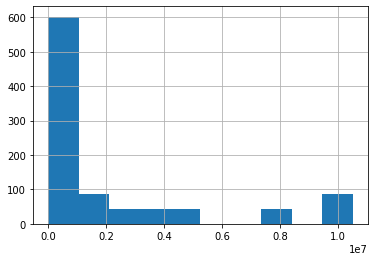

In [7]:
df_contact_success_pd["Contract Amount (yr)"].hist()

<AxesSubplot:>

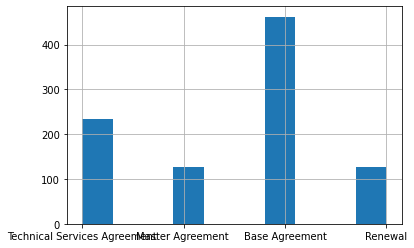

In [8]:
df_contact_success_pd["Contract Type"].hist()

<AxesSubplot:>

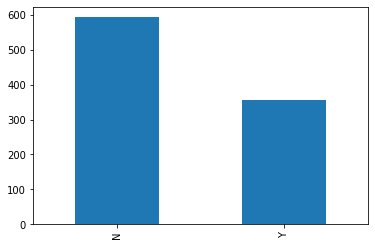

In [9]:
df_contact_success_pd["Successful Contract"].value_counts().plot.bar()

<a id="prepare_data"></a>
## 3. Data preparation
[Top](#top)

Data preparation is a very important step in machine learning model building. This is because the model can perform well only when the data it is trained on is good and well prepared. Hence, this step consumes bulk of data scientist's time spent building models.

During this process, we identify categorical columns in the dataset. Categories needed to be indexed, which means the string labels are converted to label indices. These label indices and encoded using One-hot encoding to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features to use categorical features.

Final step in the data preparation process is to assemble all the categorical and non-categorical columns into a feature vector. We use VectorAssembler for this. VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models.

#### Use the DataFrameMapper class to declare transformations and variable imputations.

* LabelBinarizer - Converts a categorical variable into a dummy variable (aka binary variable)
* StandardScaler - Standardize features by removing the mean and scaling to unit variance, z = (x - u) / s

See docs: 
* https://github.com/scikit-learn-contrib/sklearn-pandas
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
* https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [10]:
# Defining the categorical and numeric columns 
categoricalColumns = ["Successful Contract", "Effective Date", "Termination Date", "Duration Range", "Contract Range", "Vendor Quality",
                      "On Time", "Budget", "Deliverable Type", "Sourcing Organization", "Expense Type", "Budget Line Item", "Auto Renewal",
                      "Indemnification", "Supplier", "Contract Number", "Disclaimer", "Oligation", "Amendment", "Deliverables", "Force Majeure",
                      "Liability", "Payment Terms & Billing", "Term & Termination", "Contract Type", "Location", "Currency", "Intellectual Property"]
                      
numericColumns = ["Duration Days", "Contract Amount (yr)"]

In [11]:
mapper = DataFrameMapper([
    (['Duration Range'], LabelBinarizer()),
    (['Contract Range'], LabelBinarizer()),
    (['Vendor Quality'], LabelBinarizer()),
    (['On Time'], LabelBinarizer()),
    (['Budget'], LabelBinarizer()),
    (['Deliverable Type'], LabelBinarizer()),
    (['Sourcing Organization'], LabelBinarizer()),
    (['Expense Type'], LabelBinarizer()),
    (['Auto Renewal'], LabelBinarizer()),
    (['Indemnification'], LabelBinarizer()),
    (['Supplier'], LabelBinarizer()),
    (['Disclaimer'], LabelBinarizer()),
    (['Oligation'], LabelBinarizer()),
    (['Amendment'], LabelBinarizer()),
    (['Deliverables'], LabelBinarizer()),
    (['Force Majeure'], LabelBinarizer()),
    (['Liability'], LabelBinarizer()),
    (['Payment Terms & Billing'], LabelBinarizer()),
    (['Term & Termination'], LabelBinarizer()),
    (['Contract Type'], LabelBinarizer()),
    (['Location'], LabelBinarizer()),
    (['Intellectual Property'], LabelBinarizer())
    ], default=False)

In [12]:
df_contact_success_pd.columns

Index(['Successful Contract', 'Effective Date', 'Termination Date',
       'Duration Days', 'Duration Range', 'Contract Amount (yr)',
       'Contract Range', 'Vendor Quality', 'On Time', 'Budget',
       'Deliverable Type', 'Sourcing Organization', 'Expense Type',
       'Budget Line Item', 'Auto Renewal', 'Indemnification', 'Supplier',
       'Contract Number', 'Disclaimer', 'Oligation', 'Amendment',
       'Deliverables', 'Force Majeure', 'Liability', 'Payment Terms & Billing',
       'Term & Termination', 'Contract Type', 'Location', 'Currency',
       'Intellectual Property'],
      dtype='object')

In [13]:
# Define input data to the model
X = df_contact_success_pd.drop(["Successful Contract"], axis=1)

In [14]:
X.shape

(949, 29)

In [15]:
# Define the target variable and encode with value between 0 and n_classes-1
le = LabelEncoder()
y = le.fit_transform(df_contact_success_pd['Successful Contract'])

In [16]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

<a id="build_model"></a>
## 4. Build Random Forest classification model
[Top](#top)

We instantiate a decision-tree based classification algorithm, namely, RandomForestClassifier. Next we define a pipeline to chain together the various transformers and estimaters defined during the data preparation step before. Sklearn standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow.

We split original dataset into train and test datasets. We fit the pipeline to training data and apply the trained model to transform test data and generate churn risk class prediction

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Instantiate the Classifier
random_forest = RandomForestClassifier(random_state=5)

# Define the steps in the pipeline to sequentially apply a list of transforms and the estimator, i.e. RandomForestClassifier
steps = [('mapper', mapper),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)

# train the model
model=pipeline.fit( X_train, y_train )

model

Pipeline(steps=[('mapper',
                 DataFrameMapper(features=[(['Duration Range'],
                                            LabelBinarizer()),
                                           (['Contract Range'],
                                            LabelBinarizer()),
                                           (['Vendor Quality'],
                                            LabelBinarizer()),
                                           (['On Time'], LabelBinarizer()),
                                           (['Budget'], LabelBinarizer()),
                                           (['Deliverable Type'],
                                            LabelBinarizer()),
                                           (['Sourcing Organization'],
                                            LabelBinarizer()),
                                           (['Expense Type'], LabelBinarizer()),
                                           (['Auto Re...
                                        

In [19]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = model.predict( X_test )


In [20]:
# show first 10 rows of predictions
y_prediction[0:10,]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
# show first 10 rows of predictions with the corresponding labels
le.inverse_transform(y_prediction)[0:10]

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'], dtype=object)

### Model results

In a supervised classification problem such as churn risk classification, we have a true output and a model-generated predicted output for each data point. For this reason, the results for each data point can be assigned to one of four categories:

1. True Positive (TP) - label is positive and prediction is also positive
2. True Negative (TN) - label is negative and prediction is also negative
3. False Positive (FP) - label is negative but prediction is positive
4. False Negative (FN) - label is positive but prediction is negative

These four numbers are the building blocks for most classifier evaluation metrics. A fundamental point when considering classifier evaluation is that pure accuracy (i.e. was the prediction correct or incorrect) is not generally a good metric. The reason for this is because a dataset may be highly unbalanced. For example, if a model is designed to predict fraud from a dataset where 95% of the data points are not fraud and 5% of the data points are fraud, then a naive classifier that predicts not fraud, regardless of input, will be 95% accurate. For this reason, metrics like precision and recall are typically used because they take into account the type of error. In most applications there is some desired balance between precision and recall, which can be captured by combining the two into a single metric, called the F-measure.

In [22]:
# display label mapping to assist with interpretation of the model results
label_mapping=le.inverse_transform([0,1])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])

0:  N
1:  Y


In [23]:
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )

### and print the report
print(report)

              precision    recall  f1-score   support

           0       0.58      0.92      0.72       169
           1       0.28      0.04      0.07       116

    accuracy                           0.56       285
   macro avg       0.43      0.48      0.40       285
weighted avg       0.46      0.56      0.45       285



In [24]:
print('Accuracy:   ',sklearn.metrics.accuracy_score( y_test, y_prediction ))

Accuracy:    0.5649122807017544


#### Get the column names of the transformed features

In [25]:
m_step=pipeline.named_steps['mapper']

In [26]:
m_step.transformed_names_

['Duration Range_High',
 'Duration Range_Low',
 'Duration Range_Medium',
 'Contract Range_High',
 'Contract Range_Low',
 'Contract Range_Medium',
 'Vendor Quality_1',
 'Vendor Quality_3',
 'Vendor Quality_4',
 'Vendor Quality_5',
 'On Time',
 'Budget_At Budget',
 'Budget_Over Budget',
 'Budget_Under Budget',
 'Deliverable Type_Equipment',
 'Deliverable Type_Infrastructure',
 'Deliverable Type_Services',
 'Deliverable Type_Software',
 'Sourcing Organization_Claims',
 'Sourcing Organization_Finance',
 'Sourcing Organization_HR',
 'Sourcing Organization_IT',
 'Sourcing Organization_Operations',
 'Expense Type',
 'Auto Renewal',
 'Indemnification',
 'Supplier_ International Business Machines Corporation',
 'Supplier_Epicor Software Corporation',
 'Supplier_Koya Art Effects',
 'Supplier_Seligence LLC',
 'Supplier_Stanfield Systems Incorporated',
 'Disclaimer',
 'Oligation',
 'Amendment',
 'Deliverables',
 'Force Majeure',
 'Liability',
 'Payment Terms & Billing',
 'Term & Termination',
 'Co

In [27]:
features = m_step.transformed_names_

In [28]:
# Get the features importance
importances = pipeline.named_steps['RandonForestClassifier'][1].feature_importances_
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

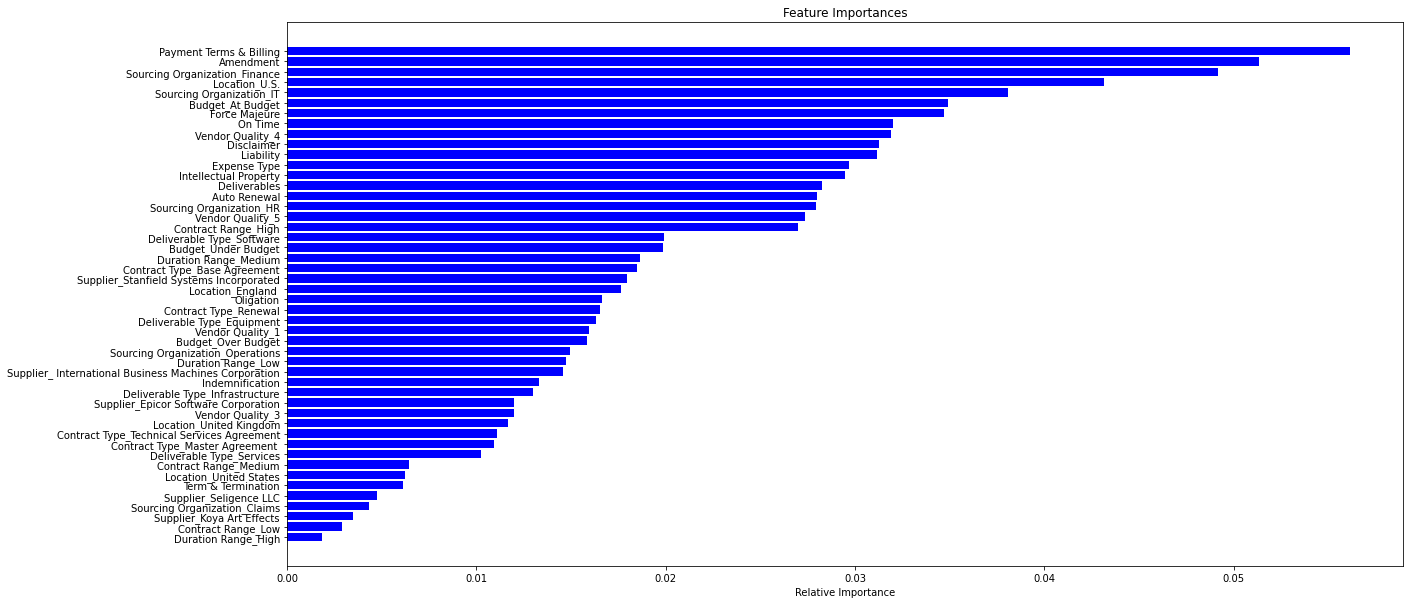

In [29]:
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

<a id="save_model"></a>
## 5. Save the model into WML Deployment Space
[Top](#top)

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space.

The steps involved for saving and deploying the model are as follows:

1. Create a new deployment space. Enter the name of the space in the cell below. Specify a tag for the space in the code cell below. This tag will be used in the future to identify this space. If a space with specified space_name already exists, existing space will be deleted before creating a new space.
2. Set this deployment space as the default space.
3. Store the model pipeline in the deployment space. Enter the name for the model in the cell below. Specify a tag for the model in the cell below.
4. Deploy the saved model. Enter the deployment name in the cell below. Specifu a tag for the deployment. Similarily, this tag will be used in the future to identify this deployment.
5. Retrieve the scoring endpoint to score the model with a payload
5. We will use the watson_machine_learning_client package to complete these steps. 

In [30]:
# Specify a names for the space being created, the saved model and the model deployment
space_name = 'Customer Contract Deployment Space'
space_tag = 'Customer Contract Deployment Space-tag'

model_name = 'customer_contract_model'
model_tag = 'customer_contract_model_tag'
model_desc = 'Customer Contract model built using Python 3.8 and scikit-learn_0.23'

deployment_name = 'customer_contact_model_python_deployment'
deployment_tag = 'customer_contract_deployment_tag'

In [31]:
!pip install watson_machine_learning_client

     |████████████████████████████████| 538 kB 17.3 MB/s eta 0:00:01


In [32]:
api_key = 'PksqW6ozAbQt_Iws8bVx_WzwxmxUBOF_CD77aRpGBWp7'
location = 'us-south'
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

!pip install -U ibm-watson-machine-learning
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

If a space with specified space_name already exists, delete the existing space before creating a new one.

### 5.1 Create Deployment Space

In [34]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(5)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    #space_meta_data = {
    #    client.spaces.ConfigurationMetaNames.NAME : space_name
    # 
    #    }
    
    space_meta_data = {
    'name': space_name,
    'description': space_name,
    'storage': {
        'type': 'bmcos_object_storage',
        'resource_crn': 'crn:v1:bluemix:public:cloud-object-storage:global:a/d3abab6720aa4f4c7cf2cf5360312bd3:9ae8378a-01e0-4db0-b7df-255558056e31::'
    },
    'compute': {
        'name': 'Machine Learning- ML',
        'crn': 'crn:v1:bluemix:public:pm-20:us-south:a/d3abab6720aa4f4c7cf2cf5360312bd3:82b85ddc-8ea5-491f-bc8d-1ea1a9b271d5::'
        }
    }
    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Customer Contract Deployment Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().


In [36]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
runtime-22.1-py3.9             12b83a17-24d8-5082-900f-0ab31fbfd3cb  base
scikit-learn_0.22-py3.6        154010f

### 5.2 Store The Model

In [37]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.8")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.DESCRIPTION: model_desc,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid ,
    client.repository.ModelMetaNames.TAGS: [model_tag]
}

stored_model_details = client.repository.store_model(model=model, meta_props=metadata, training_data=X_train, training_target=y_train, feature_names=X_train.columns)
stored_model_details

Note: Warnings!! :  Software specification default_py3.8 specified for the wml_model is deprecated and will be removed in the future. We recommend you use runtime-22.1-py3.9 instead. For details see Supported Frameworks https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html


{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'l1',
  'software_spec': {'id': 'ab9e1b80-f2ce-592c-a7d2-4f2344f77194',
   'name': 'default_py3.8'},
  'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
     'endpoint_url': 'not_applicable',
     'secret_access_key': 'not_applicable'},
    'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'Effective Date', 'type': 'object'},
      {'name': 'Termination Date', 'type': 'object'},
      {'name': 'Duration Days', 'type': 'int64'},
      {'name': 'Duration Range', 'type': 'object'},
      {'name': 'Contract Amount (yr)', 'type': 'int64'},
      {'name': 'Contract Range', 'type': 'object'},
      {'name': 'Vendor Quality', 'type': 'int64'},
      {'name': 'On Time', 'type': 'object'},
      {'name': 'Budget', 'type': 'object'},
      {'name': 'Deliverable Type', 'type': 'object'},
      {'name': 'Sourcing Organization', 'type': 'object'},
      {'name': 'Expense Type', 'type': '

### 5.3 Deploy The Model

In [38]:
# deploy the model pipeline
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [ deployment_tag],
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# deploy the model

model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)
deployment_details



#######################################################################################

Synchronous deployment creation for uid: '8e98daf7-f76c-459c-939b-45bb8c92f68f' started

#######################################################################################


initializing
Note: Software specification default_py3.8 is deprecated. Use runtime-22.1-py3.9 software specification instead. For details, see https://dataplatform.cloud.ibm.com/docs/content/wsj/wmls/wmls-deploy-python-types.html?context=cpdaas.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9d41e28b-336d-4f38-8efb-1071da0d53b9'
------------------------------------------------------------------------------------------------




{'entity': {'asset': {'id': '8e98daf7-f76c-459c-939b-45bb8c92f68f'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'e7ed1d6c-2e89-42d7-aed5-863b972c1d2b',
   'name': 'S',
   'num_nodes': 1},
  'name': 'customer_contact_model_python_deployment',
  'online': {},
  'space_id': 'd11afe88-2343-41b8-9736-6c51ee02dd9d',
  'status': {'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/9d41e28b-336d-4f38-8efb-1071da0d53b9/predictions'},
   'serving_urls': ['https://us-south.ml.cloud.ibm.com/ml/v4/deployments/9d41e28b-336d-4f38-8efb-1071da0d53b9/predictions'],
   'state': 'ready'}},
 'metadata': {'created_at': '2022-04-20T18:39:00.041Z',
  'id': '9d41e28b-336d-4f38-8efb-1071da0d53b9',
  'modified_at': '2022-04-20T18:39:00.041Z',
  'name': 'customer_contact_model_python_deployment',
  'owner': 'IBMid-270004FPGB',
  'space_id': 'd11afe88-2343-41b8-9736-6c51ee02dd9d',
  'tags': ['customer_contract_deployment_tag']},
 'system': {'warnings': [{'id'

### 5.4 Find the scoring endpoint

In [39]:
# retrieve the scoring endpoint
scoring_endpoint = client.deployments.get_scoring_href(deployment_details)

print('Scoring Endpoint:   ',scoring_endpoint)

Scoring Endpoint:    https://us-south.ml.cloud.ibm.com/ml/v4/deployments/9d41e28b-336d-4f38-8efb-1071da0d53b9/predictions
